In [10]:
from ipynb.fs.defs.MLCP_EDA import data_importing, replace_numbers_with_letters
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import plotly.express as px

import xgboost

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

# Assessing feature importance thanks to XGBoost (gradient-boosted tree regressor model)

In [11]:
# Import the dataset of features and target, and merge them together
data = data_importing(verbose = False)
dataset = pd.concat([data[1], replace_numbers_with_letters(data[-1], mode = 'label')], axis = 1)

# Print a row as example
print('Sample dataset:\n', dataset.head(1).T)

Sample dataset:
                              0
b'j_zlogz'           -3.488422
b'j_c1_b0_mmdt'       0.471864
b'j_c1_b1_mmdt'       0.058537
b'j_c1_b2_mmdt'       0.014659
b'j_c2_b1_mmdt'       0.109481
b'j_c2_b2_mmdt'       0.025472
b'j_d2_b1_mmdt'       1.870292
b'j_d2_b2_mmdt'       1.737580
b'j_d2_a1_b1_mmdt'    1.870292
b'j_d2_a1_b2_mmdt'    0.211365
b'j_m2_b1_mmdt'       0.089198
b'j_m2_b2_mmdt'       0.032309
b'j_n2_b1_mmdt'       0.331585
b'j_n2_b2_mmdt'       0.155772
b'j_mass_mmdt'      141.861038
b'j_multiplicity'    85.000000
label                 0.000000


In [12]:
# 80% of the dataset will be used as train and the remaining part as testing
# Using "stratify" we make sure the random shuffling will take into account the original distribution of each class

X_train, X_test, y_train, y_test = train_test_split(
    dataset.iloc[:,:16], dataset.iloc[:,-1], test_size=0.2, stratify=dataset.iloc[:,-1], random_state=42)

Actual class vs. predicted: 
       y_test  y_pred
4298       1       1
9908       4       4
1473       3       3
3028       0       4
1322       3       1
9835       1       1
8123       2       2
5515       3       2
7329       4       4
3105       4       4

 Classification report:
               precision    recall  f1-score   support

           0       0.69      0.75      0.72       394
           1       0.60      0.69      0.64       394
           2       0.81      0.75      0.78       393
           3       0.89      0.73      0.80       405
           4       0.80      0.82      0.81       414

    accuracy                           0.75      2000
   macro avg       0.76      0.75      0.75      2000
weighted avg       0.76      0.75      0.75      2000



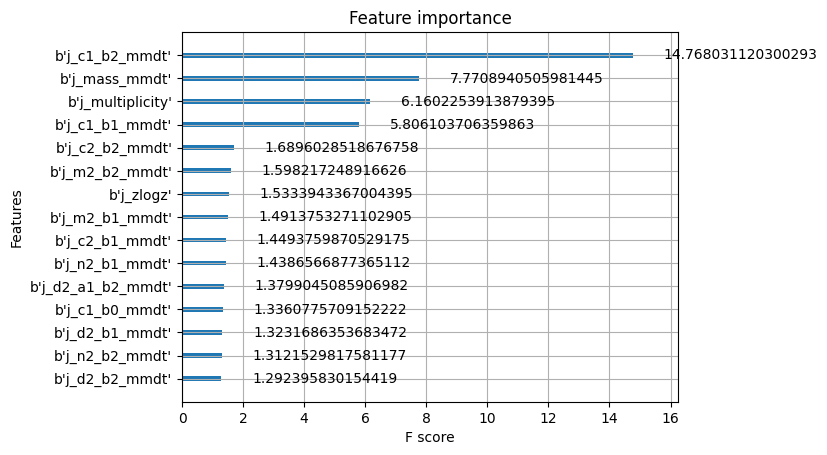

In [13]:
# Dirty work for gradient boosting; naive model used below

model = xgboost.XGBClassifier(max_depth = 5, eta = 0.3, objective = 'multi:softmax', num_class = 5)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Print actual class vs. predicted
print('Actual class vs. predicted: \n', pd.DataFrame({'y_test': y_test[:10], 'y_pred': y_pred[:10]}))

# macro avg row as benchmark
print('\n Classification report:\n', classification_report(y_test, y_pred))

# "gain" importance type tells how much the performance of a model increases once you add that variable to the tree
xgboost.plot_importance(model, importance_type='gain');

# Principal Commponent Analysis, PCA
Reducing the dimensionality of the problem, still getting good approximation of each observation's features

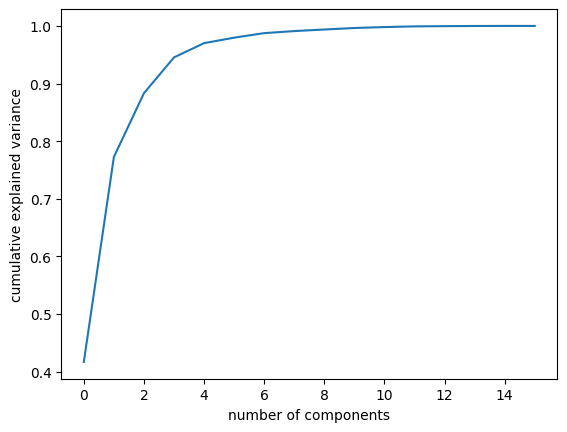

In [14]:
def PCA_prepr():

    # PCA is affected by different scale of variables, so it's better to scale them
    scaler = StandardScaler()
    dataset_pca = scaler.fit_transform(dataset.iloc[:,:16])

    # How to choose the number of output columns (or "components")? Using the "Elbow Method"
    pca = PCA().fit(dataset_pca.data)

    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')
    plt.show()

    return dataset_pca

dataset_scaled = PCA_prepr()

Explained variance ratio using 2 components: 
 0.7726539160672996


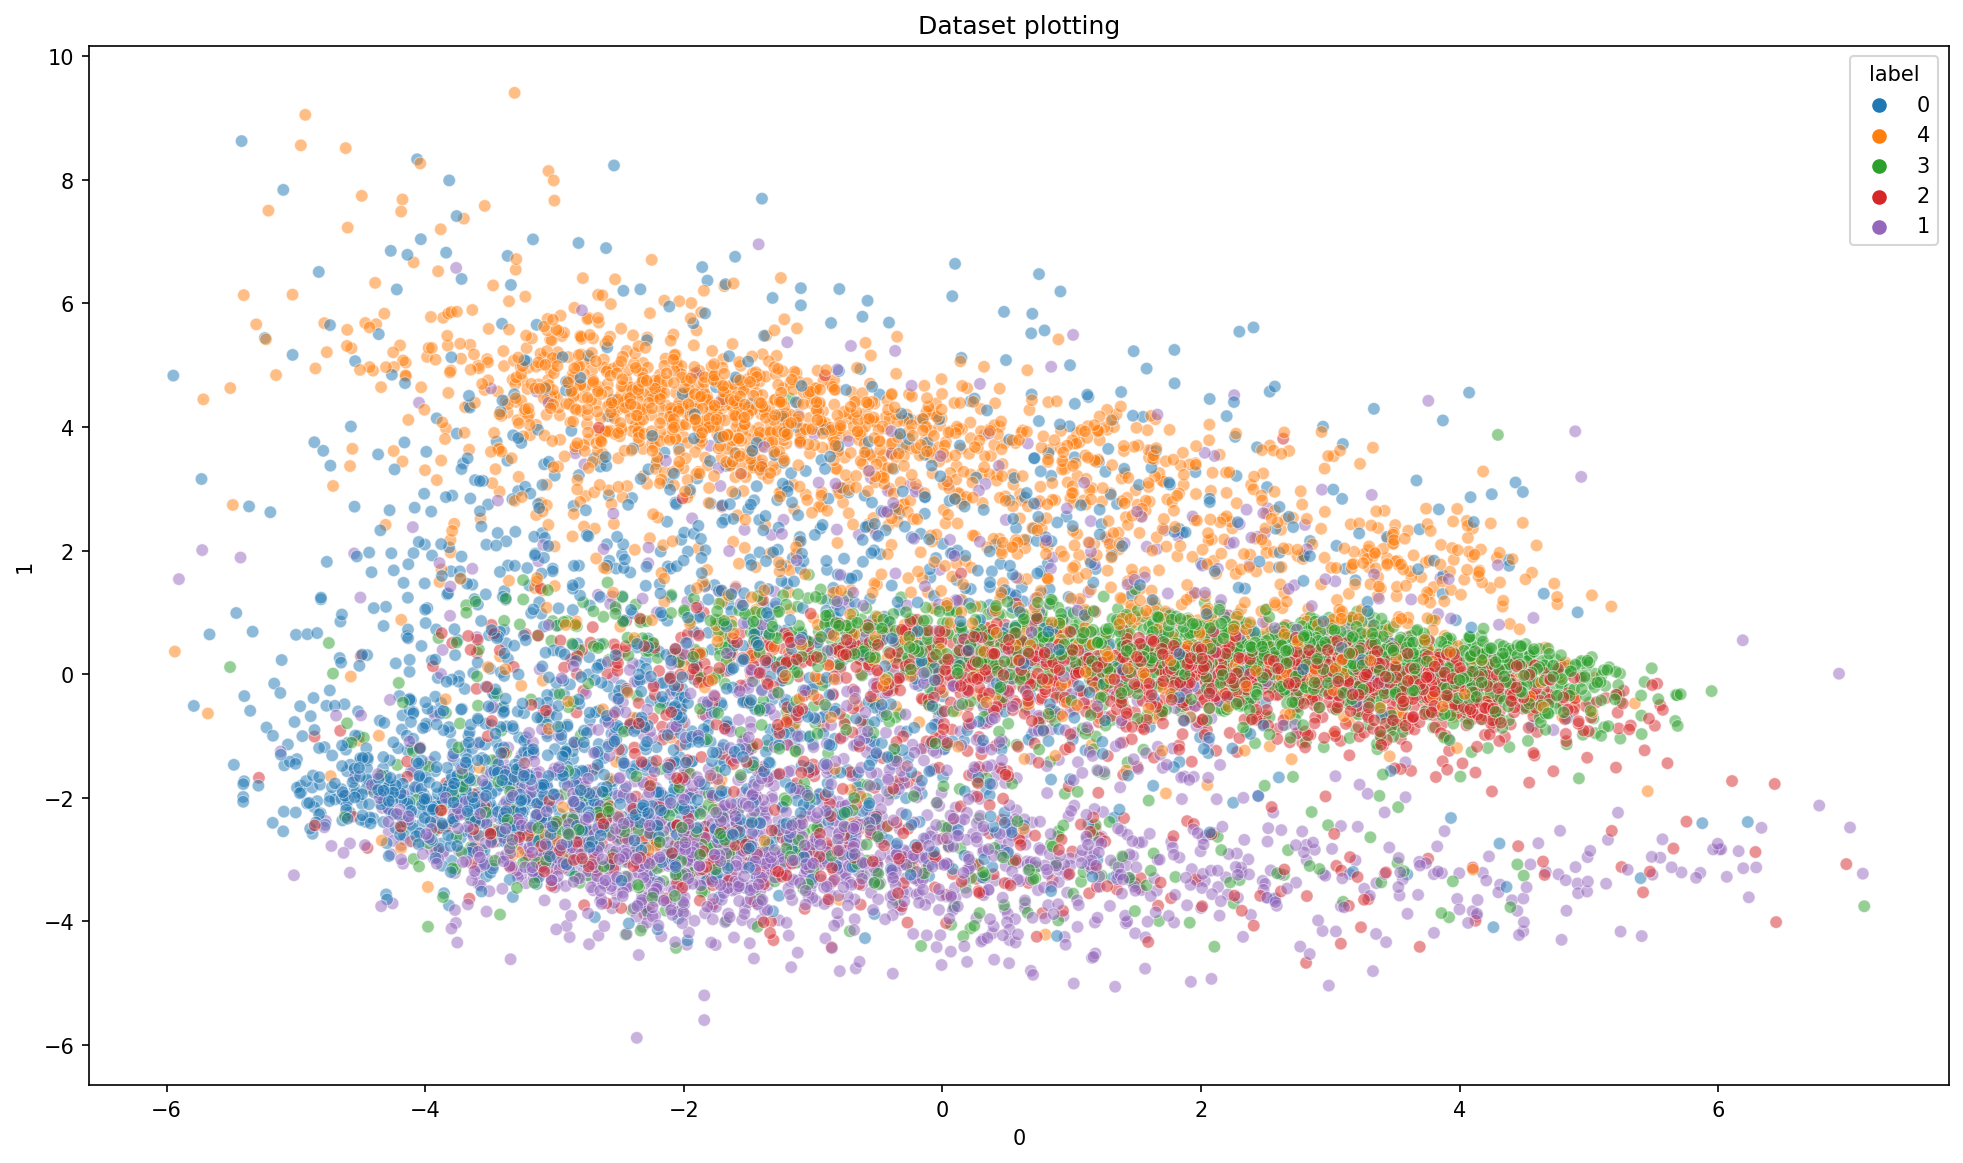

Explained variance ratio using 3 components: 
 0.8832793419053289


In [15]:
def PCA_def(number_of_components):

    # 3 components would be perfect, but choosing 2, we can easily plot data with a 77% explained variance ratio (3 cmpts. will add up to 88%)
    pca = PCA(number_of_components)
    dataset_scaled_pca = pca.fit_transform(dataset_scaled)
    print('Explained variance ratio using {} components: \n'.format(number_of_components), pca.explained_variance_ratio_.sum())

    # Concatenate PCA dataset with taregt
    dataset_scaled_pca = pd.concat([pd.DataFrame(dataset_scaled_pca), dataset.iloc[:,-1]], axis = 1)
    dataset_scaled_pca["label"] = dataset_scaled_pca["label"].astype(str)

    # Plot the PCA dataset, once 2D, once 3D
    if number_of_components == 2:
        plt.figure(figsize=(16,9), dpi = 150)
        sns.scatterplot(
            x=0, y=1,
            hue="label",
            palette=sns.color_palette("tab10", 5),
            data=dataset_scaled_pca,
            legend="full",
            alpha=0.5)
        plt.title('Dataset plotting')
        plt.show()

    elif number_of_components == 3:
        fig = px.scatter_3d(dataset_scaled_pca, x=0, y=1, z=2, color='label', opacity = 0.7, title = 'Dataset plotting')
        fig.show(renderer = 'browser')

    return dataset_scaled_pca

dataset_scaled_2_pca = PCA_def(2)
dataset_scaled_3_pca = PCA_def(3)

### Randomized Search CV
or *refining the naive XGBoost model*. **Not useful right now**, maybe later

In [8]:
from sklearn.model_selection import RandomizedSearchCV

classifier = xgboost.XGBClassifier(objective = 'multi:softmax', num_class = 5)

params = {"learning_rate" : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.4, 0.5],
          "max_depth" : [3, 4, 5, 6, 8, 10, 12],
          "n_estimators" : [20, 50, 100, 150, 200],
          "subsample" : [.3, .6, .9],
          "colsample_bytree" : [.3, .6]}

rs_model=RandomizedSearchCV(classifier,
                            param_distributions=params,
                            n_iter=5,
                            n_jobs=-1,
                            cv=5,
                            verbose=3)

rs_model.fit(X_train, y_train)
y_pred = rs_model.predict(X_test)
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
              precision    recall  f1-score   support

           0       0.70      0.73      0.71       394
           1       0.60      0.68      0.64       394
           2       0.78      0.76      0.77       393
           3       0.87      0.74      0.80       405
           4       0.80      0.80      0.80       414

    accuracy                           0.74      2000
   macro avg       0.75      0.74      0.74      2000
weighted avg       0.75      0.74      0.74      2000

